# SageMaker Built-In Linear Learner Algorithm - Model for Predicting Medicare Average Hospital Spending:
In this notebook, we show how to build a Model to predict Medicare spending per beneficiary at a hospital based on state and national average costs using Amazon SageMaker. This notebook contains code instructions for all the steps for building, training and deploying a machine learning model using SageMaker built-in Linear Learner algorithm. In this example, the notebook is created on a "ml.c4.xlarge" instance. Use the 'conda_python3' environment for the notebook.

## Learning Objectives:
This workshop covers both the preprocessing using SageMaker algorithms and other Python libraries. The major learnings are:

1. Load data into SageMaker Notebooks
2. Perform basic preprocessing including: feature cleaning, normalization and basic feature engineering.
3. Perform basic feature selection/subsampling.
4. Perform exploratory data analysis.
5. Build, train, and deploy Linear Learner regression model.

## Business Problem:
Medicare is a national health insurance program, administered by the Center for Medicare and Medicaid Services (CMS). This is a primary health insurance for Americans who are aged 65 and older. Medicare has published historical data showing hospital’s average spending for Medicare Part A and Part B claims based on different claim types and claim periods covering 1 to 3 days prior to hospital admission up to 30 days after discharge from hospital admission. These hospital spending are price standardized and non-risk adjusted, since risk adjustment is done at the episode level of the claims spanning the entire period during the episode. The hospital average costs are listed against the corresponding state level average cost and national level average cost.

In this notebook, the data is used to build a machine learning model using Amazon SageMaker built-in Linear Learner algorithm, which predicts average hospital spending cost based on the average state level spending and average national level spending. The predicted cost can be used for purposes of budget and for negotiating pricing with the hospitals. From the hospital’s perspective, the predicted average hospital spending provides visibility to claim financials that can be used by the hospitals to increase their efficiency and level of care.

## Public Dataset Used:
Medicare has published dataset showing average hospital spending on Medicare Part A and Part B claims. Both the links below refer to the same data set, one is listed in the healthdata.gov site and the other is listed at the data.medicare.gov site. The data dictionary is described in the link marked as #2 below. The dataset has hospital spending data from the year 2018 and has 67,826 data rows spanning across 13 columns. For the purposes of our analysis and machine learning, we use the dataset in csv (Comma Separated Values) format.
1.	https://healthdata.gov/dataset/medicare-hospital-spending-claim
2.	https://data.medicare.gov/Hospital-Compare/Medicare-Hospital-Spending-by-Claim/nrth-mfg3

A direct link to download the dataset to local computer can be accessed at this link - https://data.medicare.gov/api/views/nrth-mfg3/rows.csv?accessType=DOWNLOAD

In [46]:
import boto3
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pandas.plotting import scatter_matrix
import sagemaker
from sagemaker import get_execution_role
from sagemaker import image_uris
from sagemaker.deserializers import JSONDeserializer
from sagemaker.s3 import S3Uploader, S3Downloader
from sagemaker.serializers import CSVSerializer
import seaborn as sn
from sklearn.feature_selection import chi2
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import scale

In [47]:
sagemaker_session = sagemaker.Session()

# Data Preprocessing on the Raw Dataset:
In this section we read the raw csv data set into a pandas data frame. We inspect the data using pandas head() function. We do data pre-processing using feature encoding, feature engineering, column renaming, dropping some columns that have no relevance to the prediction of `Avg_Hosp` cost and examining there are no missing values in the data set.

**Note**: Many of these transformations and preprocessing steps are for demonstration purposes only and may not correspond to the optimal transformations for a specific column.

In [48]:
# Read the CSV file into panda dataframe and save it to another table so we can keep a copy of the original dataset
# In our example we use the dataframe called table1 for all pre-processing, while the dataframe table
# maintains a copy of the original data

table = pd.read_csv("data/Medicare_Hospital_Spending_by_Claim.csv")
table1 = table.copy()
table1.head()

,Facility ID,Facility Name,State,Period,Claim Type,Avg Spending Per Episode Hospital,Avg Spending Per Episode State,Avg Spending Per Episode Nation,Percent of Spending Hospital,Percent of Spending State,Percent of Spending Nation,Start Date,End Date
0,670102,AD HOSPITAL EAST LLC,TX,1 to 3 days Prior to Index Hospital Admission,Hospice,0,1,1,0.00%,0.00%,0.00%,01/01/2018,12/31/2018
1,670102,AD HOSPITAL EAST LLC,TX,1 to 3 days Prior to Index Hospital Admission,Inpatient,0,7,7,0.00%,0.03%,0.03%,01/01/2018,12/31/2018
2,670102,AD HOSPITAL EAST LLC,TX,1 to 3 days Prior to Index Hospital Admission,Outpatient,48,140,152,0.17%,0.60%,0.70%,01/01/2018,12/31/2018
3,670102,AD HOSPITAL EAST LLC,TX,1 to 3 days Prior to Index Hospital Admission,Skilled Nursing Facility,0,3,2,0.00%,0.01%,0.01%,01/01/2018,12/31/2018
4,670102,AD HOSPITAL EAST LLC,TX,1 to 3 days Prior to Index Hospital Admission,Durable Medical Equipment,0,8,8,0.00%,0.03%,0.04%,01/01/2018,12/31/2018


In [49]:
# Encode column "State"

replace_map = {
    "State": {
        "AK": 1,
        "AL": 2,
        "AR": 3,
        "AZ": 4,
        "CA": 5,
        "CO": 6,
        "CT": 7,
        "DC": 8,
        "DE": 9,
        "FL": 10,
        "GA": 11,
        "HI": 12,
        "IA": 13,
        "ID": 14,
        "IL": 15,
        "IN": 16,
        "KS": 17,
        "KY": 18,
        "LA": 19,
        "MA": 20,
        "ME": 21,
        "MI": 22,
        "MN": 23,
        "MO": 24,
        "MS": 25,
        "MT": 26,
        "NC": 27,
        "ND": 28,
        "NE": 29,
        "NH": 30,
        "NJ": 31,
        "NM": 32,
        "NV": 33,
        "NY": 34,
        "OH": 35,
        "OK": 36,
        "OR": 37,
        "PA": 38,
        "RI": 39,
        "SC": 40,
        "SD": 41,
        "TN": 42,
        "TX": 43,
        "UT": 44,
        "VA": 45,
        "VT": 46,
        "WA": 47,
        "WI": 48,
        "WV": 49,
        "WY": 50,
    }
}
table1.replace(replace_map, inplace=True)

In [50]:
# Encode column "Period"

replace_map = {
    "Period": {
        "1 to 3 days Prior to Index Hospital Admission": 1,
        "During Index Hospital Admission": 2,
        "1 through 30 days After Discharge from Index Hospital Admission": 3,
        "Complete Episode": 4,
    }
}
table1.replace(replace_map, inplace=True)

In [51]:
# Encode column "Claim Type"

replace_map = {
    "Claim Type": {
        "Home Health Agency": 1,
        "Hospice": 2,
        "Inpatient": 3,
        "Outpatient": 4,
        "Skilled Nursing Facility": 5,
        "Durable Medical Equipment": 6,
        "Carrier": 7,
        "Total": 8,
    }
}
table1.replace(replace_map, inplace=True)

In [52]:
# Convert the column "Percent of Spending Hospital	Percent of Spending" to float, remove the percent sign and
# divide by 100 to normalize for percentage

table1["Percent of Spending Hospital"] = (
    table1["Percent of Spending Hospital"].str.rstrip("%").astype("float")
)
table1["Percent of Spending Hospital"] = table1["Percent of Spending Hospital"] / 100

In [53]:
# Convert the column "Percent of Spending State" to float, remove the percent sign and
# divide by 100 to normalize for percentage

table1["Percent of Spending State"] = (
    table1["Percent of Spending State"].str.rstrip("%").astype("float")
)
table1["Percent of Spending State"] = table1["Percent of Spending State"] / 100

In [54]:
# Convert the column "Percent of Spending Nation" to float, remove the percent sign and
# divide by 100 to normalize for percentage

table1["Percent of Spending Nation"] = (
    table1["Percent of Spending Nation"].str.rstrip("%").astype("float")
)
table1["Percent of Spending Nation"] = table1["Percent of Spending Nation"] / 100

In [55]:
# Drop Column "Facility Name", Facility Id related to the facility, hence facility name is not
# relevant for the model

table1.drop(["Facility Name"], axis=1, inplace=True)

In [56]:
# Move the "Avg Spending Per Episode Hospital" column to the beginning, since the
# algorithm requires the prediction column at the beginning

col_name = "Avg Spending Per Episode Hospital"
first_col = table1.pop(col_name)
table1.insert(0, col_name, first_col)

In [57]:
# Convert integer values to float in the columns "Avg Spending Per Episode Hospital",
# "Avg Spending Per Episode State" and "Avg Spending Per Episode Nation"
# Columns with integer values are interpreted as categorical values. Changing to float avoids any mis-interpretetaion

table1["Avg Spending Per Episode Hospital"] = table1[
    "Avg Spending Per Episode Hospital"
].astype("float")
table1["Avg Spending Per Episode State"] = table1[
    "Avg Spending Per Episode State"
].astype("float")
table1["Avg Spending Per Episode Nation"] = table1[
    "Avg Spending Per Episode Nation"
].astype("float")

In [58]:
# Rename long column names for costs and percentage costs on the hospital, state and nation,
# so they are easily referenced in the rest of this discussion

table1.rename(
    columns={
        "Avg Spending Per Episode Hospital": "Avg_Hosp",
        "Avg Spending Per Episode State": "Avg_State",
        "Avg Spending Per Episode Nation": "Avg_Nation",
        "Percent of Spending Hospital": "Percent_Hosp",
        "Percent of Spending State": "Percent_State",
        "Percent of Spending Nation": "Percent_Nation",
    },
    inplace=True,
)

In [59]:
# Convert Start Date and End Date to datetime objects, then convert them to integers. First the data is converted
# to Pandas datetime object. Then the year, month and days are extracted from the datetime object and
# multipled with some weights to convert into final integer values.

table1["Start Date"] = pd.to_datetime(table1["Start Date"])
table1["End Date"] = pd.to_datetime(table1["End Date"])
table1["Start Date"] = (
    1000 * table1["Start Date"].dt.year
    + 100 * table1["Start Date"].dt.month
    + table1["Start Date"].dt.day
)
table1["End Date"] = (
    1000 * table1["End Date"].dt.year
    + 100 * table1["End Date"].dt.month
    + table1["End Date"].dt.day
)

In [60]:
# See the first 5 rows in the dataframe to see how the changed data looks

table1.head()

,Avg_Hosp,Facility ID,State,Period,Claim Type,Avg_State,Avg_Nation,Percent_Hosp,Percent_State,Percent_Nation,Start Date,End Date
0,0.0,670102,43,1,2,1.0,1.0,0.0000,0.0000,0.0000,2018101,2019231
1,0.0,670102,43,1,3,7.0,7.0,0.0000,0.0003,0.0003,2018101,2019231
2,48.0,670102,43,1,4,140.0,152.0,0.0017,0.0060,0.0070,2018101,2019231
3,0.0,670102,43,1,5,3.0,2.0,0.0000,0.0001,0.0001,2018101,2019231
4,0.0,670102,43,1,6,8.0,8.0,0.0000,0.0003,0.0004,2018101,2019231


In [61]:
# Drop Columns "Start Date" and "End Date". The dataset is only for 2018, hence all start and end dates
# are same in each row and does not impact the model

table1.drop(["Start Date"], axis=1, inplace=True)
table1.drop(["End Date"], axis=1, inplace=True)

In [62]:
# Make sure the table do not have missing values. The following code line shows there are no missing values
# in the table

table1.isna().sum()

Avg_Hosp          0
Facility ID       0
State             0
Period            0
Claim Type        0
Avg_State         0
Avg_Nation        0
Percent_Hosp      0
Percent_State     0
Percent_Nation    0
dtype: int64

# Exploratory Data Analysis (EDA):
In this section, we perform **Exploratory Data Analysis** of the data set and use various techniques for feature selection

First, we see the scatter_matrix plot of the feature variables in the data frame as they relate to the prediction variable `Avg_Hosp` cost. For this we use the scatter_matrix function from pandas.plotting library.

The entire dataset has 67826 data rows. For analysis, we take a random sample of 400 data rows for the scatter_matrix. Before selecting the 400 random data rows, we use the scale function from sklearn.preprocessing library to appropriately scale the values of the data columns. This helps the scatter_matrix plot label decorations fit properly. This plots helps in determining if we should keep all the feature columns while training the model.

Next we use the chi2 statistical test available from sklearn.feature_selection library to find the scores of feature columns as they relate to the prediction column. This is another mechanism to determine which feature columns are relevant to keep in the model

Following that, we create and visualize the correlation matrix. This is another mechanism towards feature selection prior to training the model.

In [63]:
# After selecting the random sample of 400 data rows for the scatter_matrix analysis, this step
# uses the scale function from sklearn.preprocessing library to scale the values. A new pandas data frame is created
# that holds the sampled 400 data rows. We want to keep the original data set intact so we can use the original
# data set for the subsequent training of the model

table1_sample = table1.sample(n=400, random_state=2)
standardised_table1_sample = scale(table1_sample)

standardised_table1_sample = pd.DataFrame(
    standardised_table1_sample, index=table1_sample.index, columns=table1_sample.columns
)

In [64]:
# The scatter_matrix is plotted using a tight layout for ease of visualization within the notebook. Hence,
# in the scaled randomized sample of 400 data rows, the column names are renamed to shorter column names.

standardised_table1_sample.rename(columns={"Avg_Hosp": "A_Ho"}, inplace=True)
standardised_table1_sample.rename(columns={"Facility ID": "F_Id"}, inplace=True)
standardised_table1_sample.rename(columns={"State": "ST"}, inplace=True)
standardised_table1_sample.rename(columns={"Period": "Per"}, inplace=True)
standardised_table1_sample.rename(columns={"Claim Type": "Clm"}, inplace=True)
standardised_table1_sample.rename(columns={"Avg_State": "A_ST"}, inplace=True)
standardised_table1_sample.rename(columns={"Avg_Nation": "A_Na"}, inplace=True)
standardised_table1_sample.rename(columns={"Percent_Hosp": "P_Ho"}, inplace=True)
standardised_table1_sample.rename(columns={"Percent_State": "P_ST"}, inplace=True)
standardised_table1_sample.rename(columns={"Percent_Nation": "P_Na"}, inplace=True)

<Figure size 1100x800 with 0 Axes>

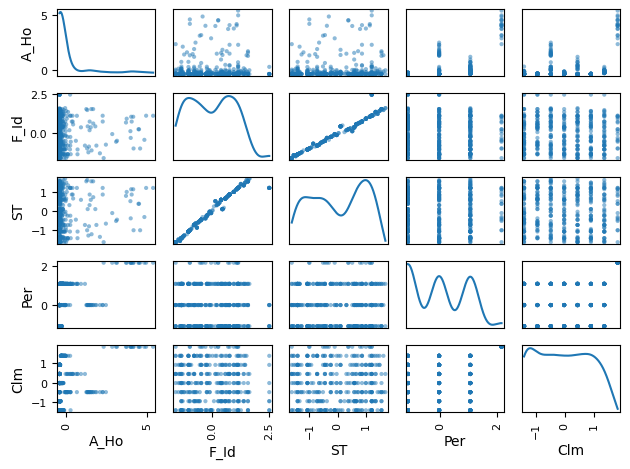

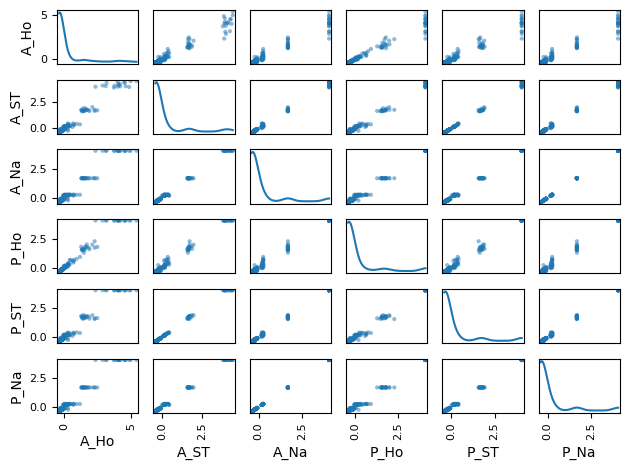

In [65]:
# In this step, the scatter matrix is plotted between the prediction column "Avg_Hosp" whose shortened name is "A_Ho"
# and each of the other remaining feature columns. For clarity of visualization, we create two scatter_matrix
# plots. The first one showing Avg_Hosp with the columns "Facility Id", "State", "Period" and "Claim Type".
# The second plot shows Avg_Hosp relation with the columns "Avg_State", "Avg_Nation", "Percent_Hosp",
# "Percent_State" and "Percent_Nation"

%matplotlib inline

plt.figure(figsize=(11, 8))
pd.plotting.scatter_matrix(
    standardised_table1_sample.loc[:, "A_Ho":"Clm"], diagonal="kde"
)
plt.tight_layout()
plt.show()

pd.plotting.scatter_matrix(
    standardised_table1_sample.loc[:, ["A_Ho", "A_ST", "A_Na", "P_Ho", "P_ST", "P_Na"]],
    diagonal="kde",
)
plt.tight_layout()
plt.show()

In [66]:
# Calculate Correlation Matrix to see how the data is related

corrMatrix = table1.corr()
print(corrMatrix)

                Avg_Hosp   Facility ID         State        Period  \
Avg_Hosp        1.000000 -8.863661e-06 -2.051140e-04  4.912669e-01   
Facility ID    -0.000009  1.000000e+00  9.821420e-01 -7.250570e-16   
State          -0.000205  9.821420e-01  1.000000e+00 -7.941509e-16   
Period          0.491267 -7.250570e-16 -7.941509e-16  1.000000e+00   
Claim Type      0.329614  1.675355e-14  1.650797e-14  1.815683e-01   
Avg_State       0.978819  8.851031e-04  6.733522e-04  4.994380e-01   
Avg_Nation      0.976734 -1.315365e-15 -1.331209e-15  5.009157e-01   
Percent_Hosp    0.982630  1.653416e-07  1.680870e-07  5.003226e-01   
Percent_State   0.977278  1.628740e-06  1.705365e-06  4.995657e-01   
Percent_Nation  0.976734  1.502742e-15  1.561542e-15  5.009206e-01   

                  Claim Type  Avg_State    Avg_Nation  Percent_Hosp  \
Avg_Hosp        3.296143e-01   0.978819  9.767342e-01  9.826304e-01   
Facility ID     1.675355e-14   0.000885 -1.315365e-15  1.653416e-07   
State           

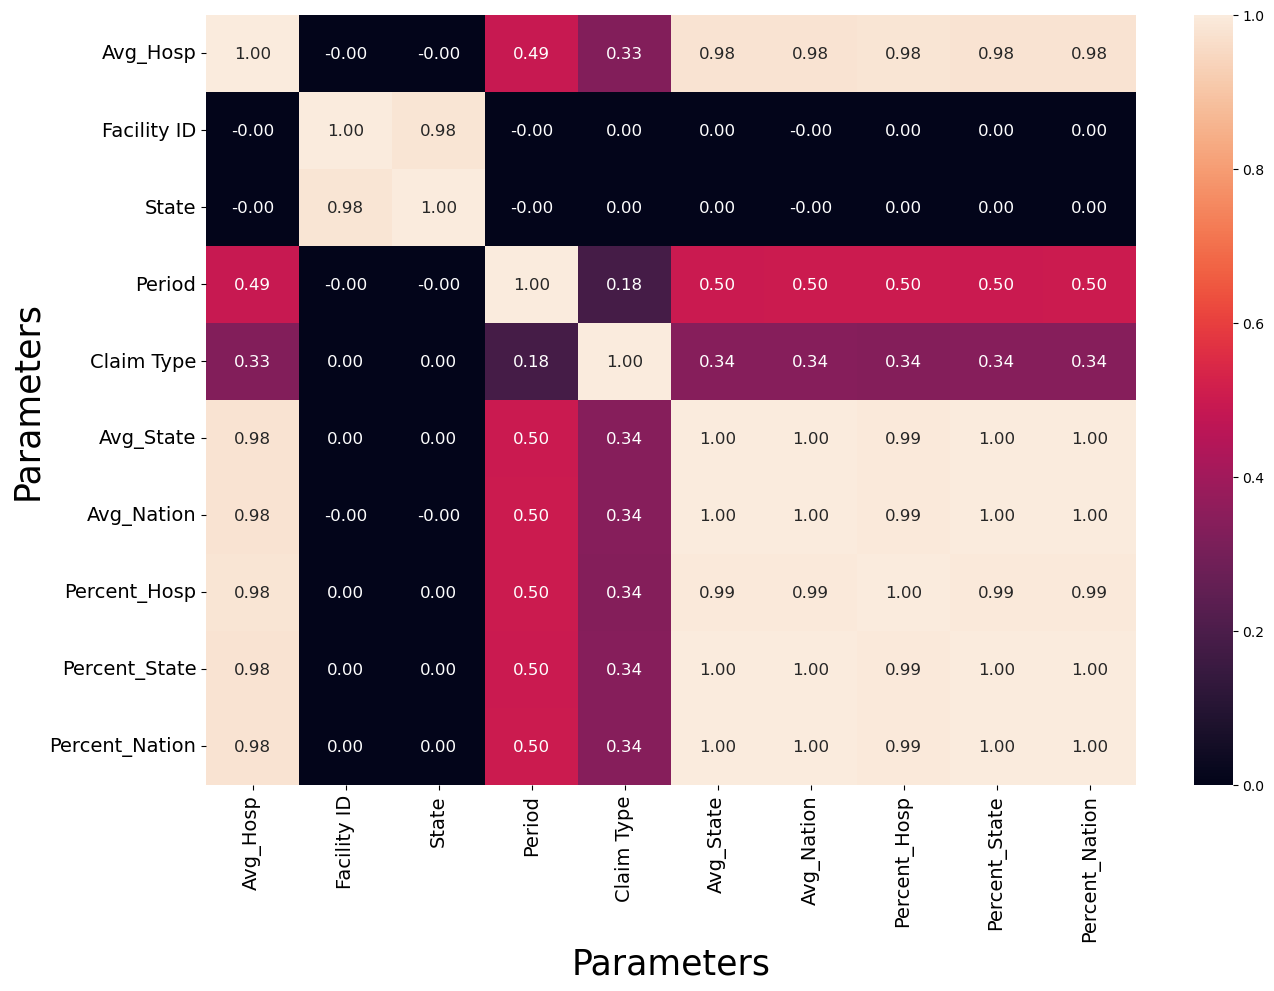

In [67]:
# Visualize Correlation matrix with Searborn and Matplotlib
plt.subplots(figsize=(15, 10))
plt.tick_params(labelsize=14)
sn.heatmap(corrMatrix, annot=True, annot_kws={"size": 12}, fmt=".2f", robust=True)
plt.xlabel("Parameters", fontsize=25)
plt.ylabel("Parameters", fontsize=25)
plt.show()

In [68]:
# Our target prediction is the column Avg_Hosp, we want to see
# how this value is correlated with the other feature columns
# From the below matrix, we see that the prediction column Avg_Hosp has the highest correlation
# with the Avg_State feature column

corrMatrix["Avg_Hosp"].sort_values(ascending=False)

Avg_Hosp          1.000000
Percent_Hosp      0.982630
Avg_State         0.978819
Percent_State     0.977278
Avg_Nation        0.976734
Percent_Nation    0.976734
Period            0.491267
Claim Type        0.329614
Facility ID      -0.000009
State            -0.000205
Name: Avg_Hosp, dtype: float64

# Creating Train, Validation and Test Datasets:
In the last step of the previous section, we see that the prediction column `Avg_Hosp` cost has second highest correlation with the `Avg_State` feature column. In this section we examine the spread of values for the `Avg_State`. Then we use a technique called stratification to categorize each data row based on the category of the `Avg_State` cost. We did not use the column `Percent_Hosp` (highest correlation) for stratification because the `Percent_Hosp` column is derived from the `Avg_Hosp` value and the line which contains the Total Cost per Episode for a specific hospital. There is an obvious expected high degree of correlation between `Avg_Hosp` and `Percent_Hosp`. Using `Percent_Hosp` to stratify values will not give us a good representative sample for train, validation and test datasets.

From the defined categories of the `Avg_State` values, we use the StratifiedShuffleSplit function from the Scikit-Learn library to split and randomly select data subsets for the training, validation and test data sets. We use this method two times. First we split the original data into train and test. Then we split the test set again into validation and test set. This stratification technique allows us to have good representation of data in each of the train, validation and test sets that are well spread across the `Avg_State` value categories. Then we move the prediction column `Avg_Hosp` to the first column in each of the train, validation and test data sets. The data sets are uploaded into S3 bucket location during the machine learning model creation process.

/var/folders/dp/ptvpdfys2x52y3h5dbzn3j900000gn/T/ipykernel_86891/3860931478.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sn.distplot(table1.Avg_State)


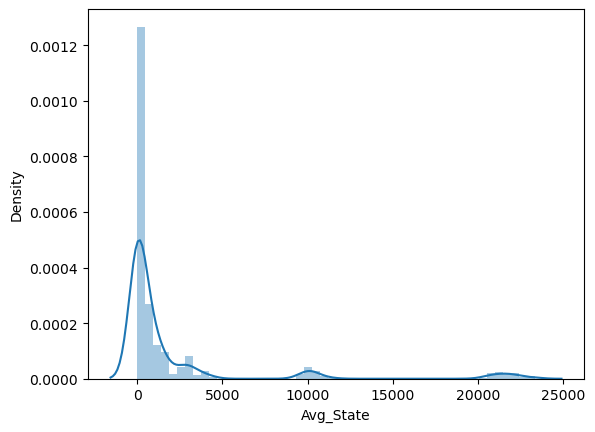

In [69]:
# We see the distribution of the data around the feature column "Avg_State" that has the highest
# correlation to the target prediction "Avg_Hosp"
# From the histogram below we see that most of the values are between 0 and 5000 for Avg_State

sn.distplot(table1.Avg_State)
plt.show()

In [70]:
# Before we divide this dataset into train, validation and test, we need to stratify the values of Avg_State
# to ensure we effectively select random sets of data into the train, validation and test data sets
# which is good representative sample based on the Avg_State values
# To do this, we introduce a new Feature column column called "Avg_State_Category", we make this column
# equal to the value of the respective Avg_State value divided by 1000 and then using the ceil (ceiling) function

table1["Avg_State_Category"] = np.ceil(table1["Avg_State"] / 1000)

In [71]:
# Now see how these categories are distributed by aggregating across all the data rows

table1.Avg_State_Category.value_counts().sort_index()

0.0     14226
1.0     35069
2.0      6325
3.0      3561
4.0      2007
5.0       472
10.0     1060
11.0     1749
12.0      274
20.0        9
21.0      750
22.0     1482
23.0      544
24.0      298
Name: Avg_State_Category, dtype: int64

In [72]:
# From the above distribution, we see approximately 61k out of the total 67k values have category 0.0 to 5.0
# Only about 6k values of the total (approx 9%) of the values have category greater than 5.0
# Hence we update the category to 6.0 for all data rows that have category greater than 5.0

table1["Avg_State_Category"].where(table1["Avg_State_Category"] < 5, 6.0, inplace=True)

In [73]:
# We see the distribution of the values for the Avg_State_Category across the category values 0.0 to 6.0

table1.Avg_State_Category.value_counts().sort_index()

0.0    14226
1.0    35069
2.0     6325
3.0     3561
4.0     2007
6.0     6638
Name: Avg_State_Category, dtype: int64

In [76]:
table1.to_csv("training_data_load_test.csv")

In [74]:
# We use the stratified shuffle split function available within sklearn library to create
# train, validation and test datasets based on our defined perentages and splitting the data appropriately
# and randomly across all the established categories with respect to the Avg_State values

# The function splits the data into two parts. First we split into training set which will be 80% of the data
# and a test set which will be 20% of the data. Then we split this test set into validation set
# where the validation set will be 90% of the previous test set and the final test set is
# the remaining 10% of the previous test set. This is a two fold splitting

# First lets create the training set and the temporray set
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(table1, table1["Avg_State_Category"]):
    strat_train_set = table1.loc[train_index]
    strat_test_set = table1.loc[test_index]

In [30]:
# Here we take the test set and split it into the validation set and the test set
# as mentioned in the prior step
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

for train_index, test_index in split.split(
    strat_test_set, strat_test_set["Avg_State_Category"]
):
    strat_validation_set = table1.loc[train_index]
    strat_test_set = table1.loc[test_index]

In [31]:
# Print total rows of data from the original dataset, training set, validation set and test set
# To see the numbers match up, add the training, validation and test data set record counts to get the total in the
# original data set

Total = table1.shape[0]
Train = strat_train_set.shape[0]
Validation = strat_validation_set.shape[0]
Test = strat_test_set.shape[0]
Total, Train, Validation, Test

(67826, 54260, 12209, 1357)

In [32]:
# Drop the column "Avg_State_category" from train, validation and test datasets. This column
# was introduced to do stratification of the data for meaningful sampling and is not relevant
# for the model anymore

strat_train_set.drop(["Avg_State_Category"], axis=1, inplace=True)
strat_validation_set.drop(["Avg_State_Category"], axis=1, inplace=True)
strat_test_set.drop(["Avg_State_Category"], axis=1, inplace=True)

In [33]:
# Replace the bucket name with the your bucket name obtained form the CloudFormation output tab
# From the SageMaker library, we use the get_execution_role function to get the execution
# role for SageMaker to access AWS reqources while creating the machine learning model

# Define IAM role
role = get_execution_role()
bucket = "ag-aws-workshop-july23-dev"

#############
# Insert your user profile name
# The profile name is on the top right corner of the window
# I.e. gcc-leonard-tan
#############
prefix = "" 

try:
    assert len(prefix) != 0
except AssertionError as e:
    print("""################################################
Please set the prefix as your user profile name
################################################""")
    raise (e)

In [34]:
# Split each of the Train, Validation and Test datasets from pandas data frame into two subsets.
# The x subset is the feature columns and the y subset is the label column

x_train = strat_train_set.iloc[:, 1:10]
y_train = strat_train_set.iloc[:, 0:1]

x_validation = strat_validation_set.iloc[:, 1:10]
y_validation = strat_validation_set.iloc[:, 0:1]

x_test = strat_test_set.iloc[:, 1:10]
y_test = strat_test_set.iloc[:, 0:1]

train_df = pd.concat([y_train, x_train], axis=1)
validation_df = pd.concat([y_validation, x_validation], axis=1)
test_df = pd.concat([y_test, x_test], axis=1)

# copy the training dataframe to s3
train_df.to_csv("data/train_data.csv", index=False, header=False)
validation_df.to_csv("data/validation_data.csv", index=False, header=False)
test_df.to_csv("data/test_data.csv", index=False, header=False)

train_data_location = f"s3://{bucket}/{prefix}/data/train"
validation_data_location = f"s3://{bucket}/{prefix}/data/validation"
test_data_location = f"s3://{bucket}/{prefix}/data/test"

# Upload the training data to S3
S3Uploader.upload(
    local_path="data/train_data.csv",
    desired_s3_uri=train_data_location,
    sagemaker_session=sagemaker_session,
)

# Upload the validation data to S3
S3Uploader.upload(
    local_path="data/validation_data.csv",
    desired_s3_uri=validation_data_location,
    sagemaker_session=sagemaker_session,
)

# Upload the testing data to S3
S3Uploader.upload(
    local_path="data/test_data.csv",
    desired_s3_uri=test_data_location,
    sagemaker_session=sagemaker_session,
)


output_location = f"s3://{bucket}/{prefix}/output"

train_data_location_input = sagemaker.inputs.TrainingInput(
    train_data_location,
    distribution="FullyReplicated",
    content_type="text/csv",
    s3_data_type="S3Prefix",
    record_wrapping=None,
    compression=None,
)

validation_data_location_input = sagemaker.inputs.TrainingInput(
    validation_data_location,
    distribution="FullyReplicated",
    content_type="text/csv",
    s3_data_type="S3Prefix",
    record_wrapping=None,
    compression=None,
)

# Train Machine Learning Model using Amazon SageMaker:
In this section, the SageMaker built-in Linear Learner algorithm is used to train the model using the training and validation data sets as input channels. The algorithm is used in the “Regressor” mode to train the model. The boto3 Python library for AWS and the SageMaker library for Python is used. In the step below, replace with your own **bucket name** from CloudFormation Outputs tab

In [35]:
# In this step, we initialize the Linear Learner Estimator
# We define the parameters for the estimator which will be used by SageMaker to train the model.
# In this example, we use an instance of type "ml.c4.xlarge". Note that the SageMaker built-in Linear Learner
# algorithm do not need GPU type instances mandatorily. GPU instances can be selected if the dataset is large
# and using GPU instances will help boost the performance of the model creation process.

# from sagemaker import LinearLearner
# from sagemaker.sklearn.estimator import LinearLearner


container = image_uris.retrieve(
    region=boto3.Session().region_name, framework="linear-learner"
)

sess = sagemaker.Session()

linear = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.c4.xlarge",
    output_path=output_location,
    sagemaker_session=sagemaker_session,
    disable_profiler=True,
)

linear.set_hyperparameters(predictor_type="regressor", mini_batch_size=200)

In [36]:
validation_data_location_input.config

{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix',
   'S3Uri': 's3://ag-aws-workshop-july23-dev/james/data/validation',
   'S3DataDistributionType': 'FullyReplicated'}},
 'ContentType': 'text/csv'}

In [37]:
train_data_location_input.config

{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix',
   'S3Uri': 's3://ag-aws-workshop-july23-dev/james/data/train',
   'S3DataDistributionType': 'FullyReplicated'}},
 'ContentType': 'text/csv'}

In [38]:
# In this step, we call the fit function to train the model using the training dataset and the validation dataset
# llearner.fit([train_data_location,validation_data_location])
linear.fit(
    inputs={
        "train": train_data_location_input,
        "validation": validation_data_location_input,
    },
    logs="None",
)

INFO:sagemaker:Creating training-job with name: linear-learner-2023-07-04-15-33-21-793



2023-07-04 15:33:22 Starting - Starting the training job...
2023-07-04 15:33:45 Starting - Preparing the instances for training........
2023-07-04 15:34:32 Downloading - Downloading input data...
2023-07-04 15:34:52 Training - Downloading the training image................
2023-07-04 15:36:18 Training - Training image download completed. Training in progress.........................
2023-07-04 15:38:23 Uploading - Uploading generated training model.
2023-07-04 15:38:34 Completed - Training job completed


In [39]:
# In this step, we deploy the model created in the previous step as an endpoint. In this example,
# we use an instance type of "ml.m4.xlarge" to deploy the model. Once deployed, the endpoint
# can be invoked to make inference and predict the value of the "Avg_Hosp" cost. Please note deploying the
# model to an endpoint takes a few minutes

llearner_predictor = linear.deploy(
    initial_instance_count=1, instance_type="ml.m4.xlarge"
)

INFO:sagemaker:Creating model with name: linear-learner-2023-07-04-15-38-35-753
INFO:sagemaker:Creating endpoint-config with name linear-learner-2023-07-04-15-38-35-753
INFO:sagemaker:Creating endpoint with name linear-learner-2023-07-04-15-38-35-753


-------!

In [40]:
x_test.values[0]

array([5.0107e+04, 5.0000e+00, 2.0000e+00, 4.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00])

In [41]:
llearner_predictor.endpoint_name

'linear-learner-2023-07-04-15-38-35-753'

In [42]:
x_test

,Facility ID,State,Period,Claim Type,Avg_State,Avg_Nation,Percent_Hosp,Percent_State,Percent_Nation
5380,50107,5,2,4,0.0,0.0,0.0000,0.0000,0.0000
2823,30103,4,1,6,8.0,8.0,0.0004,0.0003,0.0004
12310,90001,8,2,2,0.0,0.0,0.0000,0.0000,0.0000
9535,50701,5,1,7,585.0,585.0,0.0312,0.0262,0.0270
10433,50779,5,1,2,0.0,1.0,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...
1923,20018,1,2,1,0.0,0.0,0.0000,0.0000,0.0000
12701,100025,10,1,4,72.0,152.0,0.0067,0.0033,0.0070
1579,10139,2,3,2,198.0,149.0,0.0079,0.0095,0.0069
5863,50138,5,2,3,10415.0,10139.0,0.5356,0.4669,0.4684


In [43]:
llearner_predictor.serializer = CSVSerializer()
llearner_predictor.deserializer = JSONDeserializer()

In [44]:
llearner_predictor.predict(
    x_test.iloc()[0].tolist(), initial_args={"ContentType": "text/csv"}
)

{'predictions': [{'score': 55.096778869628906}]}

In [45]:
all_predictions = [
    llearner_predictor.predict(
        x_test.iloc()[i].tolist(), initial_args={"ContentType": "text/csv"}
    )
    for i in range(0, x_test.shape[0])
]
all_predictions_scores = [
    all_predictions[i]["predictions"][0]["score"]
    for i in range(0, len(all_predictions))
]

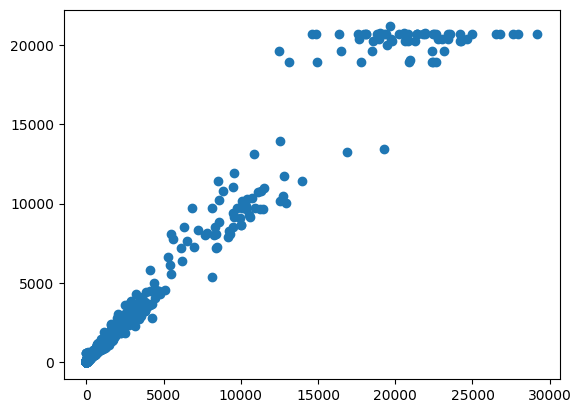

In [46]:
matplotlib.pyplot.scatter(y_test["Avg_Hosp"], all_predictions_scores)

Once you are finished testing, clean up the endpoint

In [47]:
# llearner_predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: linear-learner-2023-07-04-15-38-35-753
INFO:sagemaker:Deleting endpoint with name: linear-learner-2023-07-04-15-38-35-753


# Summary
We see how the SageMaker built-in Linear Learner algorithm is used to train machine learning model and use this model for inference. The steps show how Jupyter notebooks in SageMaker can be used for build, train and deployment of machine learning models and evaluation of metrics from the model’s performance. This approach can be used in a wide variety of use cases at scale.